/opt/conda/conda-bld/pytorch_1573049301898/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/opt/conda/conda-bld/pytorch_1573049301898/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd

0.5810813903808594


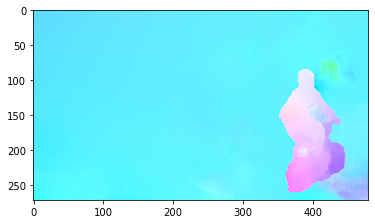

In [1]:
import cv2
import numpy as np

import torch

from PWC_src import PWC_Net
from PWC_src import flow_to_image

from pdb import set_trace as bp

FLOW_SCALE = 20.0


if __name__ == '__main__':
    # Prepare img pair (size need to be a multipler of 64)
    im1 = cv2.imread('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00002.jpg')
    im2 = cv2.imread('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00003.jpg')
    im1 = cv2.resize(im1, (1920, 1088))
    im2 = cv2.resize(im2, (1920, 1088))
    im1 = torch.from_numpy((im1/255.).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
    im2 = torch.from_numpy((im2/255.).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
    im1_v = im1.cuda()
    im2_v = im2.cuda()
    
    # Build model
    pwc = PWC_Net(model_path='/model/nnice1216/video/sintel.pytorch')
    #pwc = PWC_Net(model_path='models/chairs-things.pytorch')
    pwc = pwc.cuda()
    pwc.eval()

    import time
    start = time.time()
    flow1 = FLOW_SCALE*pwc(im2_v, im1_v)
    flow2 = FLOW_SCALE*pwc(im1_v, im2_v)
    print(time.time()-start)
    flow = flow2.data.cpu()
    flow = flow[0].numpy().transpose((1,2,0))
    flow_im = flow_to_image(flow)
    new_flow = np.sqrt(flow[:, :, 0] ** 2 + flow[:, :, 1] ** 2)
    new_flow = ((new_flow * 255) / (new_flow.max() - new_flow.min())).astype(np.uint8)
    
    # Visualization
    import matplotlib.pyplot as plt
    # plt.imshow(new_flow, cmap='binary')
    plt.imshow(flow_im)
    plt.show()

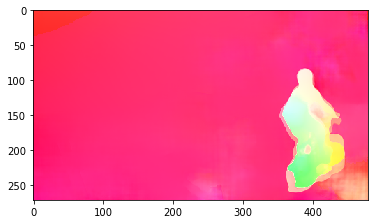

In [7]:
time = 0.6
flow = - time * (1 - time) * flow2 + (time ** 2) * flow1
flow = flow.data.cpu()
flow = flow[0].numpy().transpose((1,2,0))
flow_im = flow_to_image(flow)
plt.imshow(flow_im)
plt.show()

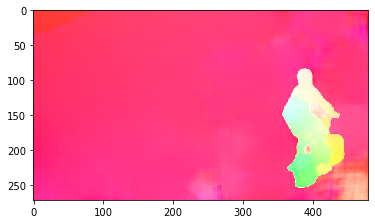

In [6]:
time = 0.9
flow = time * flow1
flow = flow.data.cpu()
flow = flow[0].numpy().transpose((1,2,0))
flow_im = flow_to_image(flow)
plt.imshow(flow_im)
plt.show()

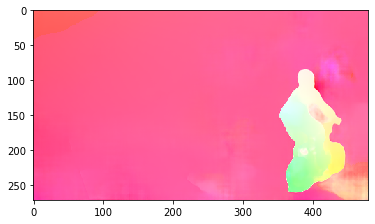

In [9]:
time = 0.9
flow = - (1 - time) * flow2
flow = flow.data.cpu()
flow = flow[0].numpy().transpose((1,2,0))
flow_im = flow_to_image(flow)
plt.imshow(flow_im)
plt.show()

In [9]:
from PIL import Image
im1 = cv2.imread('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/dolphins-show/00003.jpg')
im2 = cv2.imread('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/dolphins-show/00004.jpg')
im1 = cv2.resize(im1, (1920, 1080))
im2 = cv2.resize(im2, (1920, 1080))
im1 = torch.from_numpy((im1/255.).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
im2 = torch.from_numpy((im2/255.).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
im1_v = im1.cuda()
im2_v = im2.cuda()

In [10]:
device = 'cuda'
tenFlow = flow_up * 0.5
tenInput = im1_v
tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3], device=device).view(
            1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2], device=device).view(
            1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])
backwarp_tenGrid = torch.cat(
            [tenHorizontal, tenVertical], 1).to(device)

tenFlow = torch.cat([tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0),
                         tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0)], 1)

g = (backwarp_tenGrid + tenFlow).permute(0, 2, 3, 1)
# g = (backwarp_tenGrid).permute(0, 2, 3, 1)
# bp()
img = torch.nn.functional.grid_sample(input=tenInput, grid=g, mode='bilinear', padding_mode='border', align_corners=True)
img = (img.clamp(0, 1).detach().cpu() * 255)[0].permute(1, 2, 0).numpy().astype(np.uint8)[:, :, ::-1]
Image.fromarray(img).save('/output/flow_result.jpg')


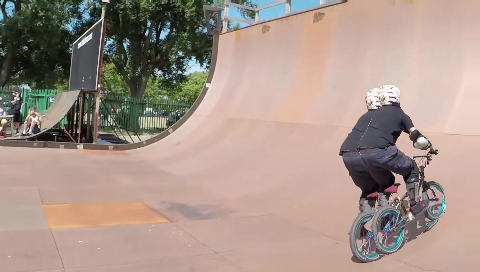

In [18]:
device = 'cuda'
time=0.85
tenFlow = -(1 - time) * time * flow2 + time * time * flow1
tenInput = im1_v
tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3], device=device).view(
            1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2], device=device).view(
            1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])
backwarp_tenGrid = torch.cat(
            [tenHorizontal, tenVertical], 1).to(device)

tenFlow = torch.cat([tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0),
                         tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0)], 1)

g = (backwarp_tenGrid + tenFlow).permute(0, 2, 3, 1)
# g = (backwarp_tenGrid).permute(0, 2, 3, 1)
# bp()
img = torch.nn.functional.grid_sample(input=tenInput, grid=g, mode='bilinear', padding_mode='border', align_corners=True)
im1 = torch.nn.functional.interpolate(im1_v, size=(272, 480), mode='bilinear', align_corners=False)
# bp()
img = ((img).clamp(0, 1).detach().cpu() * 255)[0].permute(1, 2, 0).numpy().astype(np.uint8)[:, :, ::-1]
Image.fromarray(img)

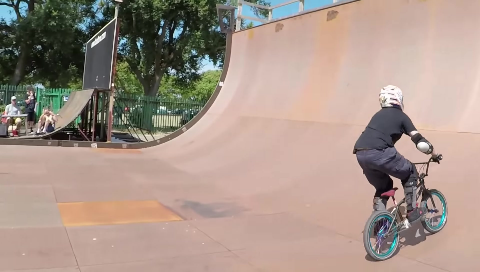

In [17]:
img = (torch.abs(im1).clamp(0, 1).detach().cpu() * 255)[0].permute(1, 2, 0).numpy().astype(np.uint8)[:, :, ::-1]
Image.fromarray(img)

In [1]:
import sys
sys.path.append('core')

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from core.raft import RAFT
from core.utils import flow_viz
from core.utils.utils import InputPadder

from pdb import set_trace as bp
from PWC_src import flow_to_image
import matplotlib.pyplot as plt

DEVICE = 'cuda'

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    # import matplotlib.pyplot as plt
    # plt.imshow(img_flo / 255.0)
    # plt.show()

    cv2.imshow('image', img_flo[:, :, [2,1,0]]/255.0)
    cv2.waitKey()


def demo(args):
    model = torch.nn.DataParallel(RAFT(args))
    model.load_state_dict(torch.load(args.model))

    model = model.module
    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        images = glob.glob(os.path.join(args.path, '*.png')) + \
                 glob.glob(os.path.join(args.path, '*.jpg'))
        
        images = sorted(images)
        imfile1 = '/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/dolphins-show/00004.jpg'
        imfile2 = '/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/dolphins-show/00003.jpg'
        image1 = load_image(imfile1)
        image2 = load_image(imfile2)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        flow = flow_low.data.cpu()
        flow = flow[0].numpy().transpose((1,2,0))
        flow_im = flow_to_image(flow)
        plt.imshow(flow_im)
        plt.show()

    return flow_up
            

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', default='/model/nnice1216/video/raft-s.pth', help="restore checkpoint")
    parser.add_argument('--path', default='/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/', help="dataset for evaluation")
    parser.add_argument('--small', action='store_true', help='use small model')
    parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
    parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
    args = parser.parse_known_args()[0]

    flow_up = demo(args)

ModuleNotFoundError: No module named 'PWC_src'

In [2]:
flow_up

tensor([[[[-66.3517, -66.5815, -66.6173,  ..., -63.9645, -63.9588, -63.9311],
          [-66.5184, -66.6080, -66.6240,  ..., -63.9953, -64.0605, -64.1608],
          [-66.5539, -66.6119, -66.6225,  ..., -63.9680, -64.0107, -64.1443],
          ...,
          [-73.1918, -73.1316, -73.1261,  ..., -63.5582, -63.5559, -63.5345],
          [-73.1776, -73.1192, -73.1171,  ..., -63.5242, -63.5132, -63.4801],
          [-73.0711, -73.1368, -73.1423,  ..., -63.4716, -63.4295, -63.3686]],

         [[ -4.0458,  -4.0232,  -4.0075,  ...,   8.6160,   8.5891,   8.5738],
          [ -4.0179,  -4.0069,  -4.0021,  ...,   8.7074,   8.6727,   8.6330],
          [ -4.0051,  -4.0048,  -4.0060,  ...,   8.7450,   8.7284,   8.6797],
          ...,
          [ 14.5210,  14.5347,  14.5408,  ...,   3.8254,   3.7973,   3.7700],
          [ 14.5186,  14.5392,  14.5355,  ...,   3.7944,   3.7467,   3.7197],
          [ 14.4872,  14.5394,  14.5303,  ...,   3.7313,   3.6908,   3.6707]]]],
       device='cuda:0')

In [4]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))
torch.save(model.state_dict(), model_path, use_new_zipfile_serialization=False)

RuntimeError: version_number <= kMaxSupportedFileFormatVersion INTERNAL ASSERT FAILED at /opt/conda/conda-bld/pytorch_1573049301898/work/caffe2/serialize/inline_container.cc:131, please report a bug to PyTorch. Attempted to read a PyTorch file with version 3, but the maximum supported version for reading is 1. Your PyTorch installation may be too old. (init at /opt/conda/conda-bld/pytorch_1573049301898/work/caffe2/serialize/inline_container.cc:131)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x47 (0x7fa38461e687 in /opt/conda/lib/python3.6/site-packages/torch/lib/libc10.so)
frame #1: caffe2::serialize::PyTorchStreamReader::init() + 0x1e9a (0x7fa38d86193a in /opt/conda/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #2: caffe2::serialize::PyTorchStreamReader::PyTorchStreamReader(std::string const&) + 0x60 (0x7fa38d862ba0 in /opt/conda/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #3: torch::jit::import_ir_module(std::shared_ptr<torch::jit::script::CompilationUnit>, std::string const&, c10::optional<c10::Device>, std::unordered_map<std::string, std::string, std::hash<std::string>, std::equal_to<std::string>, std::allocator<std::pair<std::string const, std::string> > >&) + 0x35 (0x7fa38ead1dc5 in /opt/conda/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #4: <unknown function> + 0x58f593 (0x7fa3b93d1593 in /opt/conda/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #5: <unknown function> + 0x206b86 (0x7fa3b9048b86 in /opt/conda/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #6: _PyCFunction_FastCallDict + 0x154 (0x558410b994f4 in /opt/conda/bin/python)
frame #7: <unknown function> + 0x198dac (0x558410c20dac in /opt/conda/bin/python)
frame #8: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #9: <unknown function> + 0x192274 (0x558410c1a274 in /opt/conda/bin/python)
frame #10: <unknown function> + 0x1930f1 (0x558410c1b0f1 in /opt/conda/bin/python)
frame #11: <unknown function> + 0x198e85 (0x558410c20e85 in /opt/conda/bin/python)
frame #12: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #13: PyEval_EvalCodeEx + 0x329 (0x558410c1bc09 in /opt/conda/bin/python)
frame #14: PyEval_EvalCode + 0x1c (0x558410c1c9ac in /opt/conda/bin/python)
frame #15: <unknown function> + 0x1b9067 (0x558410c41067 in /opt/conda/bin/python)
frame #16: _PyCFunction_FastCallDict + 0x91 (0x558410b99431 in /opt/conda/bin/python)
frame #17: <unknown function> + 0x198dac (0x558410c20dac in /opt/conda/bin/python)
frame #18: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #19: _PyGen_Send + 0x256 (0x558410c23e76 in /opt/conda/bin/python)
frame #20: _PyEval_EvalFrameDefault + 0x144a (0x558410c447aa in /opt/conda/bin/python)
frame #21: _PyGen_Send + 0x256 (0x558410c23e76 in /opt/conda/bin/python)
frame #22: _PyEval_EvalFrameDefault + 0x144a (0x558410c447aa in /opt/conda/bin/python)
frame #23: _PyGen_Send + 0x256 (0x558410c23e76 in /opt/conda/bin/python)
frame #24: _PyCFunction_FastCallDict + 0x115 (0x558410b994b5 in /opt/conda/bin/python)
frame #25: <unknown function> + 0x198dac (0x558410c20dac in /opt/conda/bin/python)
frame #26: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #27: <unknown function> + 0x192ebb (0x558410c1aebb in /opt/conda/bin/python)
frame #28: <unknown function> + 0x198e85 (0x558410c20e85 in /opt/conda/bin/python)
frame #29: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #30: <unknown function> + 0x192ebb (0x558410c1aebb in /opt/conda/bin/python)
frame #31: <unknown function> + 0x198e85 (0x558410c20e85 in /opt/conda/bin/python)
frame #32: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #33: <unknown function> + 0x192274 (0x558410c1a274 in /opt/conda/bin/python)
frame #34: _PyFunction_FastCallDict + 0x3d8 (0x558410c1b7e8 in /opt/conda/bin/python)
frame #35: _PyObject_FastCallDict + 0x26f (0x558410b998bf in /opt/conda/bin/python)
frame #36: _PyObject_Call_Prepend + 0x63 (0x558410b9e313 in /opt/conda/bin/python)
frame #37: PyObject_Call + 0x3e (0x558410b992fe in /opt/conda/bin/python)
frame #38: _PyEval_EvalFrameDefault + 0x1998 (0x558410c44cf8 in /opt/conda/bin/python)
frame #39: <unknown function> + 0x192416 (0x558410c1a416 in /opt/conda/bin/python)
frame #40: <unknown function> + 0x1930f1 (0x558410c1b0f1 in /opt/conda/bin/python)
frame #41: <unknown function> + 0x198e85 (0x558410c20e85 in /opt/conda/bin/python)
frame #42: _PyEval_EvalFrameDefault + 0x10c8 (0x558410c44428 in /opt/conda/bin/python)
frame #43: <unknown function> + 0x19b9f4 (0x558410c239f4 in /opt/conda/bin/python)
frame #44: _PyCFunction_FastCallDict + 0x91 (0x558410b99431 in /opt/conda/bin/python)
frame #45: <unknown function> + 0x198dac (0x558410c20dac in /opt/conda/bin/python)
frame #46: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #47: <unknown function> + 0x192416 (0x558410c1a416 in /opt/conda/bin/python)
frame #48: <unknown function> + 0x1930f1 (0x558410c1b0f1 in /opt/conda/bin/python)
frame #49: <unknown function> + 0x198e85 (0x558410c20e85 in /opt/conda/bin/python)
frame #50: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #51: <unknown function> + 0x19b9f4 (0x558410c239f4 in /opt/conda/bin/python)
frame #52: _PyCFunction_FastCallDict + 0x91 (0x558410b99431 in /opt/conda/bin/python)
frame #53: <unknown function> + 0x198dac (0x558410c20dac in /opt/conda/bin/python)
frame #54: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #55: <unknown function> + 0x192416 (0x558410c1a416 in /opt/conda/bin/python)
frame #56: <unknown function> + 0x1930f1 (0x558410c1b0f1 in /opt/conda/bin/python)
frame #57: <unknown function> + 0x198e85 (0x558410c20e85 in /opt/conda/bin/python)
frame #58: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #59: <unknown function> + 0x19b9f4 (0x558410c239f4 in /opt/conda/bin/python)
frame #60: _PyCFunction_FastCallDict + 0x91 (0x558410b99431 in /opt/conda/bin/python)
frame #61: <unknown function> + 0x198dac (0x558410c20dac in /opt/conda/bin/python)
frame #62: _PyEval_EvalFrameDefault + 0x30a (0x558410c4366a in /opt/conda/bin/python)
frame #63: <unknown function> + 0x192416 (0x558410c1a416 in /opt/conda/bin/python)


In [11]:
from PIL import Image
import cv2
import numpy as np
import torch
im1 = cv2.imread('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00003.jpg')
im2 = cv2.imread('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00004.jpg')
im1 = cv2.resize(im1, (1920, 1080))
im2 = cv2.resize(im2, (1920, 1080))
im1 = torch.from_numpy((im1/255.).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
im2 = torch.from_numpy((im2/255.).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
im1_v = im1.cuda()
im2_v = im2.cuda()

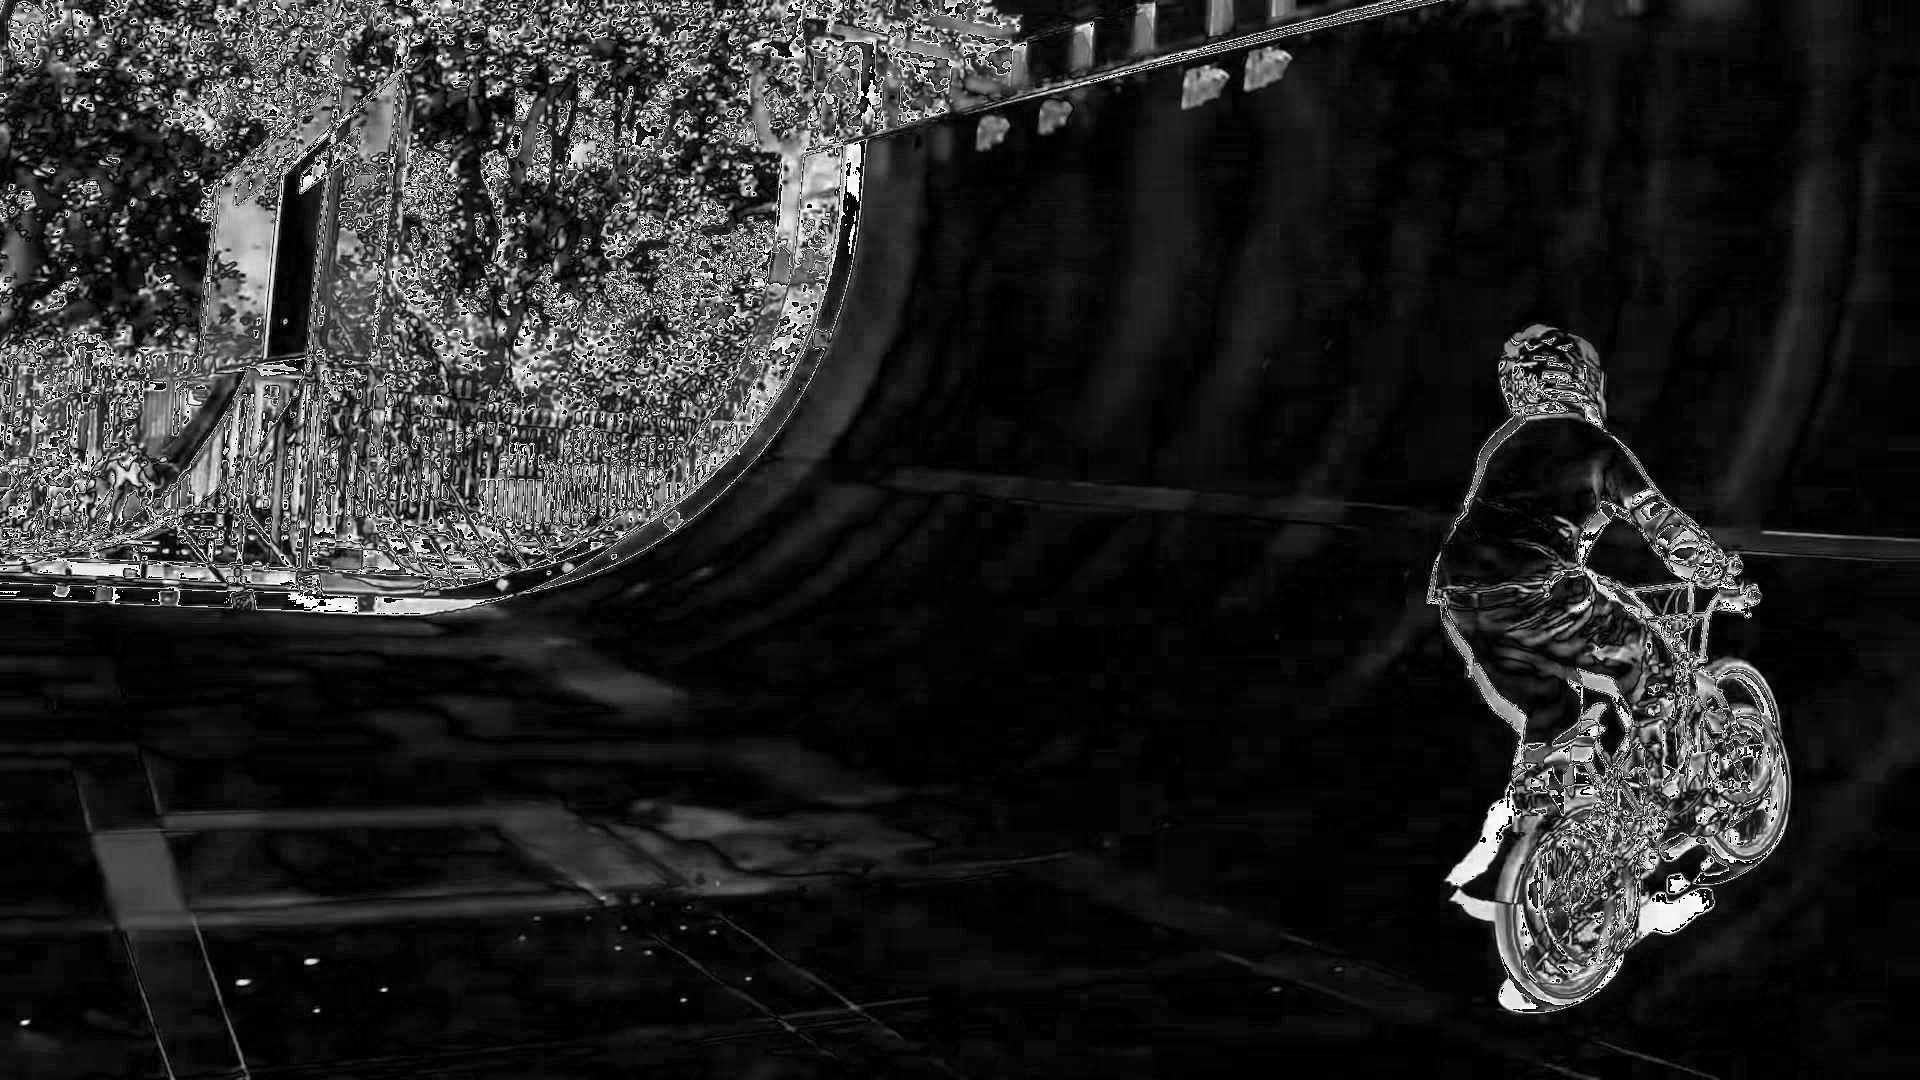

In [15]:
Image.fromarray((torch.abs(im2_v - im1_v).sum(1)[0].cpu().numpy() * 255).astype(np.uint8))